In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
from collections import Counter
import random
import tensorflow as tf
import datetime
from gensim.models import Word2Vec

/home/dongchan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 파일 열기, 기본적인 처리

In [25]:
DF = pd.read_excel('corrected_whole_review.xlsx')

In [26]:
def basic_preprocessing(string):
    if string != string or type(string) == type(1) or string == ' ':
        return ''
    else:
        return string
DF['교정된 리뷰'] = DF['교정된 리뷰'].apply(basic_preprocessing)

def length(string):
    if string == None:
        return 0
    else:
        return len(string)


DF['length'] = DF['교정된 리뷰'].apply(len)
DF = DF.drop('리뷰',axis=1)

# 게임 레이블링

In [27]:
# 수집한 리뷰 개수 확인하기
# 전처리를 통해서 많은 문장이 길이가 0이 되었으므로 0인 열을 고려하지 않는다.
truncated = DF[DF.length != 0]
trun_by_game = truncated.groupby('이름')
trun_by_game.agg('count')[['length','교정된 리뷰']]

,length,교정된 리뷰
이름,,
2018갓오브하이스쿨 with NAVER WEBTOON,4601,4601
DRAGON BALL Z 폭렬격전,3037,3037
Deemo,3681,3681
FIFA 축구,4329,4329
FINAL FANTASY BRAVE EXVIUS,4899,4899
Free Fire,4660,4660
Hidden City: 숨은물건찾기 모험,4420,4420
Hustle Castle – 마법적인 주거지 왕과 영웅,2204,2204
Idle Heroes - 아이들 히어로즈,3919,3919


In [28]:
# 레이블이 담겨있는 텍스트파일 읽기
filename1 = 'poor_game.txt'
filename2 = 'good_game.txt'
with open(filename1,'r',encoding='cp949') as fileobj:
    poor_game = fileobj.read()
with open(filename2,'r',encoding='cp949') as fileobj:
    good_game = fileobj.read()

In [29]:
# 텍스트파일에서 게임이름을 정확히 바꾸기.
poor_game = poor_game.split('\n')[:-1]
good_game = good_game.split('\n')[:-1]
poor_game[26] = '\xa0Jurassic World™:\xa0The Game'

In [30]:
# poor_game -> is_good = False
# good_game -> is_good = True
DF_list = []

for e in poor_game:
    try:
        indices = trun_by_game.groups[e]
        game_reviews = truncated.loc[indices]
    except:
        print("%s 게임 리뷰가 존재하지 않습니다"%(e))
    game_reviews['is_good'] = False
    DF_list.append(game_reviews)
for e in good_game:
    try:
        indices = trun_by_game.groups[e]
        game_reviews = truncated.loc[indices]
    except:
        print("%s 게임 리뷰가 존재하지 않습니다"%(e))
    game_reviews['is_good'] = True
    DF_list.append(game_reviews)

    
labeled_DF_ = pd.concat(DF_list)
# 촉산은 셀레늄으로 수집하다가 원인모를 에러때문에 없어짐.

촉산 for kakao 게임 리뷰가 존재하지 않습니다


In [31]:
print("Number of labeled data\n:",len(labeled_DF))
print("Number of labeled games\n:",len(np.unique(labeled_DF.이름)))
print("Number of poor games\n:",len(poor_game)-1)
print("Number of good games\n:",len(good_game))

Number of labeled data
: 407271
Number of labeled games
: 96
Number of poor games
: 77
Number of good games
: 19


# 추가적인 전처리

# 1. 특수문자 처리

In [32]:
"""
해야할 것

1. 특수문자 처리
2. 숫자를 하나의 '숫자'라는 카테고리로 통합하기
3. 일부 이모티콘 처리하기

"""

# 문장부호와 이모티콘의 분포 파악하기

etc_string = ''.join(labeled_DF['교정된 리뷰'].apply(lambda x : re.sub('[가-힣0-9 ]','',x)))
print("Length of etc string\n",len(etc_string))
counter = Counter()
counter.update(etc_string)
counter.most_common(30)

Length of etc string
 542436


[('.', 225219),
 ('?', 52591),
 ('!', 47756),
 ('~', 29625),
 ('ㅋ', 27488),
 ('ㅠ', 23227),
 ('^', 22242),
 ('ㅎ', 19397),
 (',', 14887),
 ('ㅡ', 12033),
 ('ㅜ', 8408),
 (')', 4336),
 ('ㅇ', 4199),
 ('(', 4111),
 ('♡', 3782),
 ('ㄷ', 2463),
 ('ㄱ', 2406),
 ('ㅅ', 2160),
 ("'", 1861),
 ('♥', 1716),
 (':', 1629),
 ('👍', 1626),
 ('ㅈ', 1447),
 ('%', 1248),
 ('ㄴ', 1211),
 ('ㄹ', 1199),
 ('/', 1171),
 ('+', 1085),
 ('ㆍ', 831),
 ('"', 826)]

In [161]:
counter['/']

1171

In [33]:
# 빈도가 50 이상인 기타 부호들만 처리하고 나머지는 UNK로 뭉개버리기
sorted_etc = counter.most_common()
frequently_etc = [x for x,y in sorted_etc if y >= 50]
UNK_etc = [x for x,y in sorted_etc if y < 50]
print("Number of Kind of overall etc element\n:",len(sorted_etc))
print("Number of Kind of frequently etc element\n:",len(frequently_etc))

Number of Kind of overall etc element
: 1330
Number of Kind of frequently etc element
: 94


In [34]:
'[%s]'% "|".join(UNK_etc)

'[ㄸ|👿|🐕|💖|°|好|💜|。|๑|💢|😣|ー|😅|🏻|😑|😗|し|🖕|🐱|😥|す|😐|🤣|💞|🍯|🇷|👌|●|`|🇰|※|̣|で|💓|😋|😤|🐶|∀|💘|🤔|て|🐈|▽|の|🌼|○|→|ㅖ|ㅢ|￦|😧|≥|≤|💛|🎼|´|🌟|{|😕|$|😱|||}|だ|た|が|❣|♤|😝|█|ä|に|😶|😳|😨|😬|を|💙|₩|🎮|💟|く|ま|👹|🙂|♪|¡|と|ㅚ|☞|↗|🙏|🎶|า|る|🍪|さ|な|÷|▫|ン|😜|■|😒|っ|、|！|⊙|ू|💯|บ|😏|😓|💝|ゲ|ム|か|ん|こ|ㅘ|🎵|💚|¿|《|》|👺|👋|よ|ᄏ|♧|¥|ั|เ|🎤|＼|レ|♬|う|←|「|」|玩|\U0001f929|⬆|↑|🎃|น|😻|💋|不|ω|◇|お|😔|你|☜|💎|ᄋ|🐯|ม|ก|的|▇|🏿|👊|🙌|💦|ᄒ|🙆|👀|∩|✌|🐷|￣|ド|は|も|き|思|้|很|🐴|⭐|□|日|🔴|ร|о|🍀|💪|💩|🌸|？|😯|🐲|❀|🏅|˃|˂|↓|\U0001f92c|😰|最|🚩|是|ว|▄|ﾉ|¯|̀|٩|🍓|ご|り|ア|バ|大|ㅝ|¤|︿|🤧|🎉|ง|ไ|ジ|🌍|高|😦|れ|😌|🐍|🔥|🇦|Χ|１|̨|Ⅿ|่|ย|◕|▅|🎧|🐰|😞|･|ど|め|わ|🍒|£|😲|◌|ˇ|❗|👇|ด|😩|😟|け|一|🐎|😵|ㅄ|ò|🥇|‼|游|戏|ㅙ|▷|ส|本|🙃|ㅟ|◡|ろ|げ|⚾|ে|🔲|🕴|́|\u200d|♀|🍑|😮|🐹|｀|ト|加|私|タ|ら|真|🖓|❄|♂|🏆|🏼|🎈|🎥|イ|や|💥|度|👻|🐑|楽|ᴗ|メ|🐄|🦄|é|新|🤓|🎖|🙋|🏁|ℂ|’|อ|ล|👦|面|ョ|そ|😖|⬇|出|｡|ை|カ|ラ|ス|キ|🇸|🏨|⛪|ค|💅|ﾟ|ত|্|🅱|🔵|❕|🙇|👉|👈|§|❌|و|👱|ょ|追|金|せ|【|】|€|❁|☉|☎|ற|ள|வ|ღ|🍐|🔱|🐩|😼|😸|🔪|全|🐣|😛|🐋|シ|有|意|🔫|∞|ㄳ|ね|━|ᄅ|就|更|良|🎊|ะ|ี|ห|而|做|✅|ช|ป|۶|白|つ|ヾ|👑|じ|ル|―|∧|ภ|🎅|🐼|🐉|後|দ|👄|了|🐵|👅|а|ш|р|ッ|デ|🍊|О|🐓|オ|・|む|中|ほ|₍|😿|Д|喜|欢|🌲|🌳|🌴|🌵|🌿|🖎|‿|🍫|🍣|我|̫|✧|🌙|⚽|🐽|ᅳ|🙈|ユ|ザ|間|ぜ|解|🎂|物|ち|使|要|何|🦂|┏|🏹|❥|☏|☬|♛|ஐ|ி|ம|ல|🍏|🍆|🍕|🐜|√|♣|🕊|ᗜ|🐖|啊|🎀|☠|🐤|🔜

In [35]:
# UNK로 뭉개버릴것임
labeled_DF['교정된 리뷰'] = labeled_DF['교정된 리뷰'].apply(lambda x : re.sub('[%s]'% "|".join(UNK_etc),' UNK ',x))

# 2. 숫자 통합하기

In [36]:
# 숫자를 일괄적으로 Num이라는 키워드로 통합하였다.
labeled_DF['교정된 리뷰'] = labeled_DF['교정된 리뷰'].apply(lambda x : re.sub('[0-9]+',' Num ',x))

# 3.  일부 문장부호 처리하기

In [37]:
# .. => 말줄임표(elip)
# .은 제거

labeled_DF['교정된 리뷰'] = labeled_DF['교정된 리뷰'].apply(lambda x : re.sub('[.]{2}',' Elip ',x))
labeled_DF['교정된 리뷰'] = labeled_DF['교정된 리뷰'].apply(lambda x : re.sub('[.]',' ',x))

In [47]:
# !) 이런게 있으면 형태소분석시에 !)이 뭉쳐져서 하나의 토큰으로 인식됨
# 그런현상을 막기 위해서 문장부호들을 각각 띄워주자.
# 다만 같은문자가 두개 반복되서 관용적으로 쓰이는 경우도 있으니 그런 경우도 고려해주자.
def twice_spacing(string):
    return re.sub(r'(.)\1', r' \1\1 ', string)

labeled_DF['교정된 리뷰'] = labeled_DF['교정된 리뷰'].apply(twice_spacing)

In [76]:
# 이제 두개 띄워쓰는 경우를 전부 고려했으니 한번만 있는 경우를 띄워주자.

def alone_spacing(string):
    string = re.sub(r'([^가-힣A-Za-z ])([^가-힣A-Za-z ])', r' \g<1> \g<2> ', string)
    return re.sub(r'([^가-힣A-Za-z ])\s\1',r'\1\1',string)

labeled_DF['교정된 리뷰'] = labeled_DF['교정된 리뷰'].apply(alone_spacing)

In [78]:
print('length of whole review\n:',len(' '.join(labeled_DF['교정된 리뷰'])))

labeled_DF.to_csv('labeled_df.csv')

length of whole review
: 14116853


In [79]:
labeled_DF = pd.read_csv('labeled_df.csv')

# 데이터 분석
# 1. 긴 리뷰가 많을수록 평점이 낮아질 것이다

In [23]:
labeled_DF['is_long'] = labeled_DF['교정된 리뷰'].apply(lambda x : len(x) > 100)
long_count = labeled_DF[labeled_DF.is_long].groupby('이름').agg('count').평점.values
review_by_game = labeled_DF.groupby('이름')
total_count = review_by_game.agg('count').평점.values

In [26]:
# average = 게임별 평점을 담은 리스트
# large_proportion = 게임별 긴 문장의 길이의 비율을 담은 리스트(normalize됨)

average = review_by_game.agg('mean').평점.values
long_proportion = np.array(long_count)/np.array(total_count)
long_proportion = long_proportion/max(long_proportion)

-0.590717763169051


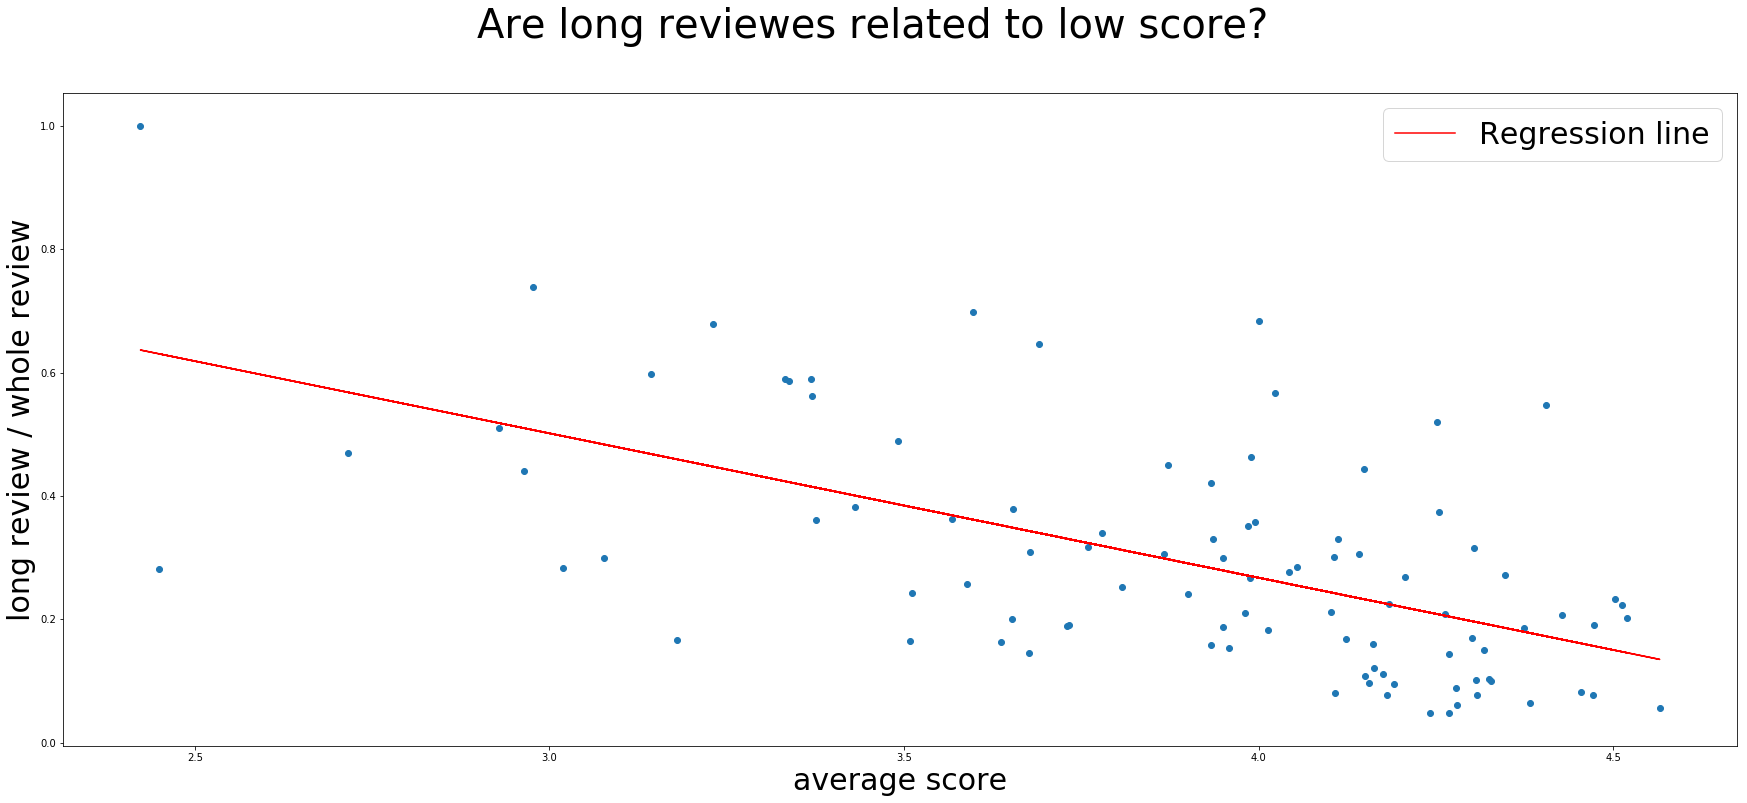

In [27]:
# 몇몇 예외적인 게임을 제외하고는 전반적으로 긴 리뷰가 많을수록 평점이 낮아진다.
fig1 = plt.figure(figsize=(30,12))
fig1.suptitle('Are long reviewes related to low score?',fontsize=40)
plt.xlabel('average score',fontsize=30)
plt.ylabel('long review / whole review',fontsize=30)
plt.scatter(average,long_proportion)

# 회귀직선까지 같이 그려보았음.
slope, intercept, r_value, p_value, std_err = stats.linregress(average,long_proportion)
line = slope*average+intercept
plt.plot(average, line, 'r', label='Regression line')
plt.legend(fontsize=30)


# 상관계수가 무려 -0.6에 달함.
print(r_value)

In [28]:
# 스피어만 상관계수검정
# 순위 기준으로 상관관계를 측정하므로 모집단에 대한 가정이 필요없음.
import scipy.stats

scipy.stats.spearmanr(average,long_proportion)
# p-value가 매우 낮으니 상관계수가 0이라는 귀무가설을 기각한다.

SpearmanrResult(correlation=-0.5827455236028215, pvalue=4.693654148860404e-10)

# 2. 망한게임과 흥한게임의 단어빈도 비교해보기

#      형태소 분석

In [82]:
# 단어빈도를 비교해보기 위해서 토크나이징을 해야함.
# 여기서는 형태소분석기로 토크나이징을 시도해보자.
from konlpy.tag import Okt
okt = Okt()

def twitter(string):
    tagged_list = okt.pos(string,stem=True,norm=True,join=True)
    
    if random.uniform(0,1) < 1e-3 and len(tagged_list) >= 5:
        print('--------------------')
        print('교정전 리뷰\n',string)
        print('\n교정후 리뷰\n','/'.join([re.search('(.*?)[/](.*)',e).group(1) for e in tagged_list]))
        
    return tagged_list

In [83]:
good_tags = labeled_DF[labeled_DF.is_good]['교정된 리뷰'].apply(twitter)
poor_tags = labeled_DF[labeled_DF.is_good == False]['교정된 리뷰'].apply(twitter)

--------------------
교정전 리뷰
 체험판    Num    판을 다했는데    Num    판이 남았다고 그러네요 이미 카드는    Num    판을 해서 종료된 상태에요

교정후 리뷰
 체험판/Num/판/을/다/하다/Num/판이/남다/그렇다/이미/카드/는/Num/판/을/하다/종료/되다/상태/에요
--------------------
교정전 리뷰
 오랜만에 복귀합니다

교정후 리뷰
 오랜/만/에/복귀/하다
--------------------
교정전 리뷰
 아니 왤케 주사위 컨트롤 할때 렉걸리고 끊기냐 대기업이란 새끼들이 최적화작업은 중소기업만도 못하네

교정후 리뷰
 아니다/왜/이렇게/주사위/컨트롤/하다/때/렉/걸리다/끊기다/대기업/이란/새끼/들/이/최적화/작업/은/중소기업/만도/못/하다
--------------------
교정전 리뷰
 진짜 운영좀 똑바로하세여 구매잘못해서 환불하고 다른거살라하니 환불자체도 안되고 안된다는 내용만뜨고 이벤트성이면 잘 기제해서    Num    회제한 뭐 제한둿다하세요 짜증나네진짜 다신 모마 결제안할겁니다

교정후 리뷰
 진짜/운영/좀/똑바로/하다/구매/잘/못/하다/환불/하고/다르다/사르다/환불/자체/도/안되다/안되다/내용/만/뜨다/이벤트/성/이면/자다/기제/하다/Num/회제/한/뭐/제/한/둿/다/하다/짜증나다/진짜/다시다/모마/결제/안/하다/겁니다
--------------------
교정전 리뷰
 앱종료당해서 다시 들어가니 하이로우에서    Num    탑인디 자동하이 되어서 전액오링 다이아사면서 하던게임인디    정내미  뚝뚝  떨어지네    

교정후 리뷰
 앱/종료/당하다/다시/들어가다/하이/로우/에서/Num/타다/자동/하이/되어다/전액/오링/다이아/사면/서/하다/게임/인/디/정/내미다/뚝뚝/떨어지다
--------------------
교정전 리뷰
 업그레이드 싴  ㆍ ㄴ   ㄷ ㄱ  ㆍ ㄴ  츽

교정후 리뷰
 업그레이드/싴/ㆍ/ㄴ/ㄷ/ㄱ/ㆍ/ㄴ/츽
--------------------
교정전 

--------------------
교정전 리뷰
 최고최고 제작자님 대박 나심니다  ♡ ☆ 

교정후 리뷰
 최고/최고/제작자/님/대박/나/심다/♡/☆
--------------------
교정전 리뷰
 재미는 있는데 깜박거려서 가끔 짜증나요  ^ * ^

교정후 리뷰
 재미/는/있다/깜박/거려/서/가끔/짜증나다/^/*/^
--------------------
교정전 리뷰
 솔직히 할께없어 다시 옴

교정후 리뷰
 솔직하다/하다/없다/다시/옴
--------------------
교정전 리뷰
 다운이 안더 ㅣ 서 구글플레이스토를 지유고도 다시  ㅎ ㅐ  ㅂ ㅗ  고 볗걸 다 해봐 ㅛ 는데 결국엔 란데네요 ㅠ 에브리타운만 다운  ㅇ ㅣ  되도 플레이가 아예 안데여    

교정후 리뷰
 다운/이/안다/ㅣ/서다/구글플레이/스토/를/지유/고도/다시/ㅎ/ㅐ/ㅂ/ㅗ/고/볗걸/다/해보다/ㅛ/는데/결국/엔/란데/네/요/ㅠ/에브리타운/만/다운/ㅇ/ㅣ/되다/플레이/가/아예/알다
--------------------
교정전 리뷰
 인터넷문제없는데 계속 접속안되네요    Elip 

교정후 리뷰
 인터넷/문제/없다/계속/접속/안되다/Elip
--------------------
교정전 리뷰
 넘 재밌고 좋아요 이런 모바일게임 만들어주셔서 감사합니다

교정후 리뷰
 넘다/재밌다/좋다/이렇다/모바일/게임/만들다/감사하다
--------------------
교정전 리뷰
 마석을 돈으로 바꿀수잇게해주새여    약살돈도없음    Elip 

교정후 리뷰
 마석/을/돈/으로/바꾸다/잇다/해주/새/여/약/살돈/도/없다/Elip
--------------------
교정전 리뷰
 처음시작해바요 기대해볼게요

교정후 리뷰
 처음/시/작/해바/요/기대/해보다
--------------------
교정전 리뷰
 레벨 난이도 조정필요한거 같아요 너무 어려운듯

교정후 리뷰
 레벨/난이도/조정/필요하다/같다/너무/어렵다
--------------------
교정전 리뷰
 몬길너는 너무갔다    El

--------------------
교정전 리뷰
 아직은 처음이라 잘모르겠지만 조금씩 기지레벨업하는 재미에 시간가는줄 모르겠습니다

교정후 리뷰
 아직/은/처음/이라/잘/모르다/조금씩/기지/레벨/업다/재미/에/시간/가다/모르다
--------------------
교정전 리뷰
 아주제밎있어여 최고

교정후 리뷰
 아주/제/밎/있다/최고
--------------------
교정전 리뷰
 업데이트어디서 하는겨   ??   자꾸 일로 넘어오긴하는데 뭘 눌러야 하냐   ??  

교정후 리뷰
 업데이트/어디서/하다/겨/??/자꾸/일로/넘어오다/뭘/누르다/하다/??
--------------------
교정전 리뷰
 다이아 사라고 이제는 대놓고 출석할때마다 홍보하네 진짜 내가 한게임들중 역대급으로 현질유도    Num    위게임 게임시작하자마자 다이아 충전하라고 메세지가 오네

교정후 리뷰
 다이아/사라/고/이제/는/대놓고/출석/하다/때/마다/홍보/하다/진짜/내/가/한게임/들/중/역대/급/으로/현질/유도/Num/위/게임/게임/시작/하/자마자/다이아/충전/하/라고/메세지/가/오다
--------------------
교정전 리뷰
 그런데 업데이트 후 접속이 안돼오

교정후 리뷰
 그런데/업데이트/후/접속/이/안/돼다
--------------------
교정전 리뷰
 음악 으로 좀비 모으는 부분에서 전리품 얻는데 클릭해도 아무반응이 없네 ? 와 내가 태어나서 이런 최악에 게임은 처음본다

교정후 리뷰
 음악/으로/좀비/모으다/부분/에서/전리품/얻다/클릭/하다/아무/반응/이/없다/?/오다/내/가/태어나다/이렇다/최악/에/게임/은/처음/보다
--------------------
교정전 리뷰
 그런데 아이템이 사용이 안되는게 있어요

교정후 리뷰
 그런데/아이템/이/사용/이/안되다/있다
--------------------
교정전 리뷰
 배경그림이 마음에 들어요

교정후 리뷰
 배경/그림/이/마음/에/들다
--------------------
교정전 리뷰
  Num   

--------------------
교정전 리뷰
 자꾸 이름이 있다네요    Elip    어떻게 해야 이름이 없을까요 ?

교정후 리뷰
 자꾸/이름/이/있다/Elip/어떻다/하다/이름/이/없다/?
--------------------
교정전 리뷰
 엄안    Num    성에 법정과 함께 출정시 노기    Num    개로 시작하여 스킬이 바로 나가야하는데 노기    Num    개로 전장에 들어가집니다   !!   확인해주셍 ·  !!  

교정후 리뷰
 엄안/Num/성/에/법정/과/함께/출정/시/놓다/Num/개/로/시작/하다/스킬/이/바로/나가야/하다/놓다/Num/개/로/전장/에/들어가다/지다/!!/확인/해주다/셍/·/!!
--------------------
교정전 리뷰
 중독성있음 근데 난이도가 높음

교정후 리뷰
 중독/성/있다/근데/난이도/가/높다
--------------------
교정전 리뷰
 재밌다    Elip    이거 너무 좋은 게임인데    Elip    안하시는 분들 좀 해보세요 엄청 재미있어요

교정후 리뷰
 재밌다/Elip/이/거/너무/좋다/게임/인데/Elip/안/하다/분들/좀/해보다/엄청/재미있다
--------------------
교정전 리뷰
 아니 들어가자마자 튕기면 뭐하라는 거야

교정후 리뷰
 아니다/들어가다/튕기/면/뭐/하/라는/거야
--------------------
교정전 리뷰
 용량 좀 줄여주세요    Elip    용량때문에 게임 다 지워도 접속이 안돼요    Elip 

교정후 리뷰
 용량/좀/줄이다/Elip/용량/때문/에/게임/다/지우다/접속/이/안/돼다/Elip
--------------------
교정전 리뷰
 좋은데 갑자기 무한 로딩 걸리네요 지웟다가 깔아도 계속 그러네요

교정후 리뷰
 좋다/갑자기/무한/로딩/걸리다/지우다/깔다/계속/그렇다
--------------------
교정전 리뷰
 너무나도 재미있어요 시간가는줄를모른다니까요

교정후 리뷰
 너무나도/재미있다/시간/가다/모르다/요
---

--------------------
교정전 리뷰
 안깔았는디 평점조은거보니까 해봐야지

교정후 리뷰
 안/깔다/평점/조/은/거보/니까/해보다
--------------------
교정전 리뷰
 짱 제미있었어요    UNK     😆 ☺ 😂

교정후 리뷰
 짱/제/밉다/UNK//☺/
--------------------
교정전 리뷰
 요즘 할만한 개임이 없었는데 간만에 좋은개임만난듯   ^^  

교정후 리뷰
 요즘/하다/한/개임/이/없다/간만/에/좋다/개임/만나다/^^
--------------------
교정전 리뷰
 어제 시작했는데 렙업도 잘되네요 ㅎ 미친듯이해서 렙    Num    Num    Num    세캐릭으로 돌리다 튕겼는데 ㅠ 다   ~~   사라짐 ㅠ 내캐릭들 몇번 시도하다 안되서 ㅠ 그냥 삭제해버림   ㅡㅡ   이제 어케하는지 알겠더니만 ㅠ 그래서 겜갈아탐 ㅠ

교정후 리뷰
 어제/시작/하다/렙업/도/잘/되다/ㅎ/미치다/하다/렙/Num/Num/Num/세/캐릭/으로/돌리다/튕/기다/ㅠ/다/~~/사라지다/ㅠ/내/캐릭/들/몇번/시도/하다/안되다/ㅠ/그냥/삭제/하다/버리다/ㅡㅡ/이제/어떻다/하다/알다/ㅠ/그래서/겜/갈아타다/ㅠ
--------------------
교정전 리뷰
 홍진영때문에 깔았지만 도저히 못하겠음    전형적인 중국 양산형 게임

교정후 리뷰
 홍진영/때문/에/깔다/도저히/못/하다/전형/적/인/중국/양산/형/게임
--------------------
교정전 리뷰
 그래픽 좋고 차별화된 게임의 재미가 있네여

교정후 리뷰
 그래픽/좋다/차별/화/되다/게임/의/재미/가/있다
--------------------
교정전 리뷰
 지른게 아까워서 하고있는 애증의게임 타격감좋고 중독성있는 뭐같은게임

교정후 리뷰
 지르다/아깝다/하다/애증/의/게임/타/격감/좋다/중독/성/있다/뭐/같다/게임
--------------------
교정전 리뷰
 음    Elip    제 폰이 똥폰인지 뭔지 모르겠는데 렉 빼고 다 좋아요 ♡

교정후 리뷰


# Word2Vec 적용 : 단어사전 생성

In [ ]:
%time good_model = Word2Vec(good_tags, size=200, window = 5, workers=6, iter=10, sg=1)
%time bad_model = Word2Vec(poor_tags, size=200, window = 5, workers=6, iter=10, sg=1)

In [2]:
good_model = Word2Vec.load('워드투벡_흥한게임')
bad_model = Word2Vec.load('워드투벡_망한게임')


In [3]:
good_vector = good_model.wv
poor_vector = bad_model.wv

good_vocab = good_vector.vocab
poor_vocab = poor_vector.vocab

In [149]:
good_vector.most_similar('씹다/Verb')

/home/dongchan/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('성질/Noun', 0.6550886631011963),
 ('존망/Noun', 0.6464184522628784),
 ('아우/Noun', 0.6426749229431152),
 ('어우/Noun', 0.6392343044281006),
 ('발암/Noun', 0.6382722854614258),
 ('천하다/Adjective', 0.6360571384429932),
 ('샘/Noun', 0.6323336362838745),
 ('퉤퉤/Noun', 0.6290369629859924),
 ('개망겜/Noun', 0.6223989129066467),
 ('마삼/Noun', 0.6220090389251709)]

In [148]:
poor_vector.most_similar('씹다/Verb')

/home/dongchan/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('똥망/Noun', 0.47655850648880005),
 ('안할랜다/Noun', 0.47159022092819214),
 ('짱꼴라/Noun', 0.4685949683189392),
 ('좆/Noun', 0.4649581015110016),
 ('병진/Noun', 0.46456092596054077),
 ('엿같다/Noun', 0.45032355189323425),
 ('개망/Noun', 0.44969916343688965),
 ('운빨똥망겜/Noun', 0.448228657245636),
 ('좇망겜/Noun', 0.4422726035118103),
 ('버러지/Noun', 0.4421132206916809)]

In [4]:
print("length of vocabulary\n good review:",len(good_vocab),'\n poor review:',len(poor_vocab))

length of vocabulary
 good review: 6297 
 poor review: 13874


In [200]:
good_model.save('워드투벡_흥한게임')
bad_model.save('워드투벡_망한게임')

# 상위 빈도 1000개의 단어를 저장해서 비교해보자

In [105]:
good_sorted = sorted(good_vocab, key = good_vocab.get, reverse=True)
poor_sorted = sorted(poor_vocab, key = poor_vocab.get, reverse=True)

In [108]:
pd.DataFrame([[good_sorted[x],poor_sorted[x]] for x in range(1000)],columns=['G','P']).to_excel('단어빈도순위.xlsx')

# 3. 감성분석

1. 최대 토큰의 길이를 정하기(=150)
2. 레이블 만들기
        점수 1,2 -> 0
        점수 4,5 -> 1
        
3. 태그의 길이를 150으로 확장하여 numpy array로 변환
        - 우리는 인덱스로 변환하고싶음.
            - 단어 : 인덱스 사전과
            - 인덱스 : 단어 리스트를 만들자.
            - 그리고, 단어를 인덱스로 바꿔서 numpy array로 저장하자.

4. 텐서플로우 알고리즘짜기

# 최대 토큰의 길이로 데이터 압축하기

In [204]:
# 최대 길이를 고정시켜야함.
good_df = labeled_DF[labeled_DF.is_good][good_tags.apply(len) < 150]
poor_df = labeled_DF[labeled_DF.is_good == False][poor_tags.apply(len) < 150]

In [205]:
print("length of df\n good review :",len(good_df),"\n poor review:",len(poor_df))

length of df
 good review : 77184 
 poor review: 330079


In [178]:
# df의 개수와 태그의 개수가 맞아야 합칠 수 있음.
good_tags = good_tags[good_tags.apply(len) < 150]
poor_tags = poor_tags[poor_tags.apply(len) < 150]

print("length of df\n good tags :",len(good_tags),"\n poor tags:",len(poor_tags))

length of df
 good tags : 77184 
 poor tags: 330079


# 레이블 만들기

In [7]:
# 3점짜리 리뷰는 쓸모없음.

#good_ex3 = good_df[good_df.평점 != 3]
#poor_ex3 = poor_df[poor_df.평점 != 3]

def score_to_label(boolean_list):
    n = len(boolean_list)
    labels = np.zeros((n,2))
    for idx in range(n):
        if boolean_list[idx]:
            labels[idx] = [1,0]
        else:
            labels[idx] = [0,1]
    return labels
    
good_labels = score_to_label((good_ex3.평점 > 3).values)
poor_labels = score_to_label((poor_ex3.평점 > 3).values)

In [13]:
# 역시 태그에서도 3점짜리 리뷰는 없애주자.

good_tags_ex3 = good_tags.loc[good_ex3.index]
poor_tags_ex3 = poor_tags.loc[poor_ex3.index]

NameError: name 'good_tags' is not defined

In [259]:
# good_tags는 리스트자료구조가 데이터프레임에 넣어져있으므로
# 이걸 그대로 df.to_csv같은 메서드 사용하면 데이터가 뭉개져버림.
# numpy array로 복원하고 저장하는게 좋을듯.
# 그러려면 사이즈를 150으로 고정해야하므로 원래 length를 feature에 넣기 위해서
# length를 기록해두자.

good_lengths = good_tags_ex3.apply(len)
poor_lengths = poor_tags_ex3.apply(len)

# 태그를 numpy array로 변환하기

In [8]:
good_word_dict = {x:y for y,x in enumerate(good_vocab.keys())}
temp1 = good_word_dict['UNK/Alpha'] 
good_word_dict['너무/Adverb'] = temp1
good_word_dict['UNK/Alpha'] = 0

poor_word_dict = {x:y for y,x in enumerate(poor_vocab.keys())}
temp2 = poor_word_dict['UNK/Alpha']
poor_word_dict['좋다/Adjective'] = temp2
poor_word_dict['UNK/Alpha'] = 0

In [9]:
good_inv_dict = list(good_word_dict.keys())
good_inv_dict[0], good_inv_dict[temp1] = good_inv_dict[temp1], good_inv_dict[0]

poor_inv_dict = list(poor_word_dict.keys())
poor_inv_dict[0], poor_inv_dict[temp2] = poor_inv_dict[temp2], poor_inv_dict[0]

In [12]:
def to_numpy_array(tags,lengths,word_dict,max_len=150):
    n = len(tags)
    tags_list = tags.values
    valid_lengths = lengths.values
    np_array = np.full((n,max_len),0)
    for idx in range(n):
        valid_length = valid_lengths[idx]
        for j in range(valid_length):
            try:
                np_array[idx][j] = word_dict[tags_list[idx][j]]
            except:
                pass
    return np_array

good_tag_array = to_numpy_array(good_tags_ex3,good_lengths,good_word_dict)
poor_tag_array = to_numpy_array(poor_tags_ex3,poor_lengths,poor_word_dict)

NameError: name 'good_tags_ex3' is not defined

In [14]:
good_ex3

,Unnamed: 0,Unnamed: 0.1,평점,시간,이름,timestamp,교정된 리뷰,length,is_good,label
0,330087,3280,4,2018-11-25,모두의마블 for kakao,1543071600,주사위 컨트롤좀 어떻게 해보세요 아 진짜 도깨비 주사위쓰는데 어떻게 주사위 컨트롤이...,39,True,1
1,330088,3281,1,2018-11-25,모두의마블 for kakao,1543071600,현질유도씹오지는거 관리자들 머릿속에 꽃밭쳐들어있냐 오류는 고치지도 않엌 ㅋㅋ ...,18,True,0
2,330089,3282,4,2018-11-25,모두의마블 for kakao,1543071600,확실히 템빨 게임이기는 한데 다른 게임 많다는 버그같은것도 없고 핵같은 것도 없는거...,54,True,1
3,330090,3283,5,2018-11-25,모두의마블 for kakao,1543071600,너무 현질유도를 하지않고 무과금에게도 즐거움을 줄수있게 여러가지 이벤트를 성공하기 ...,30,True,1
4,330091,3284,1,2018-11-25,모두의마블 for kakao,1543071600,르블랑 너프해 시발,4,True,0
5,330093,3286,1,2018-11-25,모두의마블 for kakao,1543071600,주작 주컨심각함 이건 고쳐야됨,9,True,0
6,330094,3287,1,2018-11-25,모두의마블 for kakao,1543071600,진짜 걍 망했구나 Elip,4,True,0
7,330095,3288,1,2018-11-25,모두의마블 for kakao,1543071600,카카 오게정꼭있어야되요 ? 저는게통이 안됬다고요,11,True,0
8,330096,3289,5,2018-11-25,모두의마블 for kakao,1543071600,일러스트 왜 없애요 Elip 그리고 중력증폭기 장난하냐 ? Num ...,45,True,1
9,330097,3290,5,2018-11-25,모두의마블 for kakao,1543071600,갓겜 처음파일좀 낮어주세요 ♡ ☆☆,8,True,1


In [261]:
print("잘 담아졌는지 비교해보기\n",good_tags_ex3.values[0],'\n----------------------\n',good_tag_array[0])

잘 담아졌는지 비교해보기
 ['주사위/Noun', '컨트롤/Noun', '좀/Noun', '어떻다/Adjective', '해보다/Verb', '아/Exclamation', '진짜/Noun', '도깨비/Noun', '주사위/Noun', '쓰다/Verb', '어떻다/Adjective', '주사위/Noun', '컨트롤/Noun', '이/Josa', '그렇게/Adverb', '튀어/Noun', '하/Exclamation', '진짜/Noun', '점수/Noun', '다/Adverb', '떨어지다/Verb', '진짜/Noun', '졸라/Noun', '빡치다/Adjective', '아/Exclamation', '진짜/Noun', '다/Adverb', '이기다/Verb', '판/Noun', '이다/Verb', '망하다/Adjective', '니/Noun', '들/Suffix', '이/Josa', '만들다/Verb', '주사위/Noun', '때문/Noun', '에/Josa', '망하다/Adjective'] 
----------------------
 [ 3  4  5  6  7  8  9 10  3 11  6  3  4 12 13 14 15  9 16 17 18  9 19 20
  8  9 17 21 22 23 24 25 26 12 27  3 28 29 24  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]


In [264]:
good_ex3['length'] = good_lengths
poor_ex3['length'] = poor_lengths

/home/dongchan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/dongchan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [266]:
good_ex3.to_csv('흥한게임_3점빼고_최종.csv')
poor_ex3.to_csv('망한게임_3점빼고_최종.csv')
np.save('흥한게임_3점빼고_인덱스.npy',good_tag_array)
np.save('망한게임_3점빼고_인덱스.npy',poor_tag_array)

In [5]:
good_tag_array = np.load('흥한게임_3점빼고_인덱스.npy')
poor_tag_array = np.load('망한게임_3점빼고_인덱스.npy')
good_ex3 = pd.read_csv('흥한게임_3점빼고_최종.csv')
poor_ex3 = pd.read_csv('망한게임_3점빼고_최종.csv')

# 텐서플로우 알고리즘짜기

input>

placeholder1 : 150차원의 정수 인덱스 벡터를 받음

placeholder2 : 1차원의 boolean label을 받음.

placeholder3 : word vector의 값을 받는 placeholder
    
Variable>

Variable1 : lookup한 벡터를 받기 위한 객체,, [vocab_size,150]차원

assign : placeholder3의 내용을 Variable1 에 할당함.

Variable2 : [150,50]차원 matrix

Variable3 : 50차원 matrix -> output

계산값>

emb : placeholder1에 assign을 통해 할당된 variable1을 lookup시킨 것


In [10]:
# test/train split

from sklearn.model_selection import train_test_split

X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(good_tag_array,
                                                            good_labels,test_size=0.15,random_state=50)
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(poor_tag_array,
                                                            poor_labels,test_size=0.15,random_state=50)

print(np.shape(X_g_train))

(60325, 150)


In [17]:
# embedding vector

def get_lookup(vectors,inv_dict):
    dim = len(vectors['UNK/Alpha'])
    vocab_size = len(inv_dict)
    print(dim,vocab_size)
    
    lookup_matrix = np.zeros((vocab_size,dim))
    for i in range(1,vocab_size):
        lookup_matrix[i] = vectors[inv_dict[i]]
        
    return lookup_matrix

good_lookup = get_lookup(good_vector,good_inv_dict)
poor_lookup = get_lookup(poor_vector,poor_inv_dict)

200 6297
200 13874


In [105]:
def train(X_train,X_test,Y_train,Y_test,lookup,learning_rate=1e-2):
    tf.reset_default_graph()
    vocab_size, emb_size = np.shape(lookup)
    train_size, max_len = np.shape(X_train)
    test_size, _ = np.shape(X_test)
    
    print("VOCABULARY SIZE:",vocab_size)
    print("EMBEDDING_DIM:",emb_size)
    print("MAX_SEQ_LENGTH:",max_len)
    
    with tf.Graph().as_default():
        config = tf.ConfigProto(
            log_device_placement=False,
            allow_soft_placement=True
        )
        config.gpu_options.allocator_type = 'BFC'
        sess = tf.Session(config=config)
        with sess.as_default():
            
            initializer = tf.contrib.layers.xavier_initializer()
            ph1 = tf.placeholder(tf.int32, shape=[None,max_len], name='input')
            # ph2는 인트값을 받지만 자료형을 float32로 해야 float인 확률값이랑 비교가 가능함.
            ph2 = tf.placeholder(tf.float32, shape=[None,2], name='label')
            ph_emb = tf.placeholder(tf.float32, shape=[vocab_size,emb_size],name='word2vec')
            batch_size = 32
            dropout_rate = tf.placeholder("float")

            with tf.device('/gpu:0'), tf.name_scope("embedding"):
                va1 = tf.Variable(tf.random_uniform([vocab_size, emb_size],
                                                    -1.0, 1.0), name="W_text",trainable=False)
                assign_op = tf.assign(va1,ph_emb)
                embedded_chars = tf.nn.embedding_lookup(va1, ph1)
                flatted_emb = tf.reshape(embedded_chars,shape=[-1,max_len*emb_size])
            
            with tf.device('/gpu:0'), tf.name_scope("fully-connected"):
            
                W_fc1 = tf.get_variable("W_fc1", shape=[max_len*emb_size,1000], initializer=initializer)
                b_fc1 = tf.get_variable("b_fc1", shape=[1000], initializer=initializer)
                fc_ = tf.nn.relu(tf.matmul(flatted_emb,W_fc1)+b_fc1, name="fc")
                fc  = tf.nn.dropout(fc_,dropout_rate)
                
                W_fc2 = tf.get_variable("W_fc2", shape=[1000,2], initializer=initializer)
                b_fc2 = tf.get_variable("b_fc2", shape=[2], initializer=initializer)
                out = tf.nn.xw_plus_b(fc,W_fc2,b_fc2)
            
            with tf.device('/gpu:0'), tf.name_scope("prediction"):
                
                costs = tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=ph2)
                cost = tf.reduce_mean(costs)
                global_step = tf.Variable(0, name="global_step", trainable=False)
                train_op = tf.train.AdadeltaOptimizer(learning_rate).minimize(cost,global_step=global_step)
                prob = tf.nn.softmax(out)
                prediction = tf.argmax(prob,axis=1)
                label = tf.argmax(ph2,axis=1)
                is_equal = tf.equal(prediction,label)
                accuracy = tf.reduce_mean(tf.cast(is_equal,tf.float32))
                
            total_loop = int(train_size/batch_size)
            print("total_loop:",total_loop)
            sess.run(tf.global_variables_initializer())
            sess.run(assign_op,feed_dict={ph_emb:lookup})
            
            for epoch in range(5):
                for idx in range(total_loop):

                    _,c,a,lb,pr = sess.run([train_op,cost,accuracy,label,prediction],
                                     {ph1:X_train[batch_size*idx:batch_size*(idx+1)],
                                      ph2:Y_train[batch_size*idx:batch_size*(idx+1)],
                                     dropout_rate:0.6})
                    
                    #o,pro,cs,f,f_,lk = sess.run([out,prob,costs,fc,fc_,embedded_chars],
                    #                 {ph1:X_train[batch_size*idx:batch_size*(idx+1)],
                    #                  ph2:Y_train[batch_size*idx:batch_size*(idx+1)]})
                    
                    if idx == epoch:
                        print("epoch = %s, step = %s, train loss = %s, train accuracy = %s"%(epoch,idx,round(c,2),round(a,2)))                    
                        #print("output\n",o)
                        #print("prob\n",pro)
                        print("label\n",lb)
                        #print("costs\n",cs)
                        print("prediction\n",pr)
                        #print("fc1\n",f)
                        #print("fc1 before relu\n",f_)
                        #print("lookup\n",lk)
                    
                    if idx % 100 == 0 and idx != 0:
                        print("epoch = %s, step = %s, train loss = %s, train accuracy = %s"%(epoch,idx,round(c,2),round(a,2)))
                        #print("output\n",o)
                        #print("prob\n",pro)
                        #print("label\n",lb)
                        #print("costs\n",cs)
                        #print("prediction\n",pr)
                        #print("fc1\n",f)
                        #print("fc1 before relu\n",f_)   
                        #print("lookup\n",lk)
                    
                    if idx % 500 == 0 and idx != 0:

                        print('\nEvaluation')

                        cost_test = 0
                        acc_test = 0
                        cnt = 0


                        num_test_batchs = int(test_size/batch_size)

                        for i in range(num_test_batchs):

                            X_batch_test = X_test[i*batch_size:(i+1)*batch_size]
                            Y_batch_test = Y_test[i*batch_size:(i+1)*batch_size]

                            feed_dict_test = {
                            ph1 : X_batch_test,
                            ph2 : Y_batch_test,
                            dropout_rate:1
                            }

                            cost_t, acc_t = sess.run(
                            [cost, accuracy], feed_dict = feed_dict_test)

                            cost_test += cost_t
                            acc_test += acc_t
                            cnt += 1
                        
                        time_str = datetime.datetime.now().isoformat()
                        print(time_str,'\n')
                        print("epoch = %s, step = %s, test loss = %s, test accuracy = %s"%(epoch,idx,round(cost_test/cnt,2)
                                                                                           ,round(acc_test/cnt,2)))
                        print('\n')

                #break



In [106]:
train(X_g_train, X_g_test, y_g_train, y_g_test,good_lookup,1e-1)

VOCABULARY SIZE: 6297
EMBEDDING_DIM: 200
MAX_SEQ_LENGTH: 150
total_loop: 1885
epoch = 0, step = 0, train loss = 0.65, train accuracy = 0.75
label
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
prediction
 [0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
epoch = 0, step = 100, train loss = 0.44, train accuracy = 0.78
epoch = 0, step = 200, train loss = 0.29, train accuracy = 0.94
epoch = 0, step = 300, train loss = 0.44, train accuracy = 0.81
epoch = 0, step = 400, train loss = 0.34, train accuracy = 0.81
epoch = 0, step = 500, train loss = 0.41, train accuracy = 0.78

Evaluation
2018-12-07T00:08:03.388740 

epoch = 0, step = 500, test loss = 0.32, test accuracy = 0.86


epoch = 0, step = 600, train loss = 0.29, train accuracy = 0.88
epoch = 0, step = 700, train loss = 0.26, train accuracy = 0.91
epoch = 0, step = 800, train loss = 0.46, train accuracy = 0.78
epoch = 0, step = 900, train loss = 0.2, train accuracy = 0.94
epoch = 0, step = 1000, train

2018-12-07T00:09:25.683790 

epoch = 4, step = 1500, test loss = 0.29, test accuracy = 0.88


epoch = 4, step = 1600, train loss = 0.25, train accuracy = 0.91
epoch = 4, step = 1700, train loss = 0.27, train accuracy = 0.88
epoch = 4, step = 1800, train loss = 0.31, train accuracy = 0.84


In [107]:
train(X_p_train, X_p_test, y_p_train, y_p_test,poor_lookup,1e-1)

VOCABULARY SIZE: 13874
EMBEDDING_DIM: 200
MAX_SEQ_LENGTH: 150
total_loop: 8011
epoch = 0, step = 0, train loss = 1.63, train accuracy = 0.31
label
 [1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1]
prediction
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
epoch = 0, step = 100, train loss = 0.45, train accuracy = 0.81
epoch = 0, step = 200, train loss = 0.35, train accuracy = 0.91
epoch = 0, step = 300, train loss = 0.23, train accuracy = 0.97
epoch = 0, step = 400, train loss = 0.32, train accuracy = 0.81
epoch = 0, step = 500, train loss = 0.4, train accuracy = 0.75

Evaluation
2018-12-07T00:09:36.720211 

epoch = 0, step = 500, test loss = 0.34, test accuracy = 0.84


epoch = 0, step = 600, train loss = 0.22, train accuracy = 0.91
epoch = 0, step = 700, train loss = 0.53, train accuracy = 0.81
epoch = 0, step = 800, train loss = 0.36, train accuracy = 0.81
epoch = 0, step = 900, train loss = 0.23, train accuracy = 0.88
epoch = 0, step = 1000, trai

epoch = 1, step = 1100, train loss = 0.26, train accuracy = 0.84
epoch = 1, step = 1200, train loss = 0.19, train accuracy = 0.91
epoch = 1, step = 1300, train loss = 0.42, train accuracy = 0.81
epoch = 1, step = 1400, train loss = 0.15, train accuracy = 0.94
epoch = 1, step = 1500, train loss = 0.35, train accuracy = 0.84

Evaluation
2018-12-07T00:11:35.265994 

epoch = 1, step = 1500, test loss = 0.28, test accuracy = 0.87


epoch = 1, step = 1600, train loss = 0.22, train accuracy = 0.88
epoch = 1, step = 1700, train loss = 0.38, train accuracy = 0.84
epoch = 1, step = 1800, train loss = 0.29, train accuracy = 0.91
epoch = 1, step = 1900, train loss = 0.3, train accuracy = 0.78
epoch = 1, step = 2000, train loss = 0.38, train accuracy = 0.81

Evaluation
2018-12-07T00:11:41.959081 

epoch = 1, step = 2000, test loss = 0.28, test accuracy = 0.87


epoch = 1, step = 2100, train loss = 0.14, train accuracy = 0.97
epoch = 1, step = 2200, train loss = 0.22, train accuracy = 0.84
epoch = 1

epoch = 2, step = 2500, train loss = 0.24, train accuracy = 0.88

Evaluation
2018-12-07T00:13:39.057144 

epoch = 2, step = 2500, test loss = 0.28, test accuracy = 0.88


epoch = 2, step = 2600, train loss = 0.14, train accuracy = 0.97
epoch = 2, step = 2700, train loss = 0.35, train accuracy = 0.88
epoch = 2, step = 2800, train loss = 0.21, train accuracy = 0.94
epoch = 2, step = 2900, train loss = 0.16, train accuracy = 0.94
epoch = 2, step = 3000, train loss = 0.23, train accuracy = 0.91

Evaluation
2018-12-07T00:13:46.026819 

epoch = 2, step = 3000, test loss = 0.27, test accuracy = 0.88


epoch = 2, step = 3100, train loss = 0.26, train accuracy = 0.94
epoch = 2, step = 3200, train loss = 0.18, train accuracy = 0.97
epoch = 2, step = 3300, train loss = 0.25, train accuracy = 0.84
epoch = 2, step = 3400, train loss = 0.31, train accuracy = 0.88
epoch = 2, step = 3500, train loss = 0.24, train accuracy = 0.91

Evaluation
2018-12-07T00:13:52.739110 

epoch = 2, step = 3500, test los

epoch = 3, step = 3800, train loss = 0.14, train accuracy = 0.94
epoch = 3, step = 3900, train loss = 0.47, train accuracy = 0.94
epoch = 3, step = 4000, train loss = 0.21, train accuracy = 0.91

Evaluation
2018-12-07T00:15:46.847513 

epoch = 3, step = 4000, test loss = 0.27, test accuracy = 0.88


epoch = 3, step = 4100, train loss = 0.14, train accuracy = 0.97
epoch = 3, step = 4200, train loss = 0.18, train accuracy = 0.91
epoch = 3, step = 4300, train loss = 0.1, train accuracy = 0.97
epoch = 3, step = 4400, train loss = 0.2, train accuracy = 0.91
epoch = 3, step = 4500, train loss = 0.28, train accuracy = 0.78

Evaluation
2018-12-07T00:15:53.414890 

epoch = 3, step = 4500, test loss = 0.27, test accuracy = 0.88


epoch = 3, step = 4600, train loss = 0.23, train accuracy = 0.88
epoch = 3, step = 4700, train loss = 0.19, train accuracy = 0.97
epoch = 3, step = 4800, train loss = 0.25, train accuracy = 0.88
epoch = 3, step = 4900, train loss = 0.14, train accuracy = 0.94
epoch = 3,

epoch = 4, step = 5100, train loss = 0.21, train accuracy = 0.84
epoch = 4, step = 5200, train loss = 0.25, train accuracy = 0.94
epoch = 4, step = 5300, train loss = 0.22, train accuracy = 0.91
epoch = 4, step = 5400, train loss = 0.15, train accuracy = 0.97
epoch = 4, step = 5500, train loss = 0.19, train accuracy = 0.91

Evaluation
2018-12-07T00:17:53.891026 

epoch = 4, step = 5500, test loss = 0.28, test accuracy = 0.88


epoch = 4, step = 5600, train loss = 0.21, train accuracy = 0.91
epoch = 4, step = 5700, train loss = 0.2, train accuracy = 0.91
epoch = 4, step = 5800, train loss = 0.17, train accuracy = 0.91
epoch = 4, step = 5900, train loss = 0.27, train accuracy = 0.84
epoch = 4, step = 6000, train loss = 0.37, train accuracy = 0.84

Evaluation
2018-12-07T00:18:00.743937 

epoch = 4, step = 6000, test loss = 0.28, test accuracy = 0.88


epoch = 4, step = 6100, train loss = 0.07, train accuracy = 1.0
epoch = 4, step = 6200, train loss = 0.24, train accuracy = 0.88
epoch = 4,